In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environments.base_env import HomeostaticEnvironment
from environments.anticipatory_env import AnticipatoryEnvironment
from models.qlearning import QLearning

# Test base_env 

In [3]:
import torch
# Définir les paramètres
initial_state = [90, 37]  # Glucose = 90, Température = 37
setpoints = [100, 37]  # Setpoints pour le glucose et la température
weights = [1, 2]  # Importance relative : température plus critique
exponents = [2, 2]  # Non-linéarité pour les calculs de drive
effects = {
    "eat": [10, 0],  # Manger augmente le glucose de 10
    "cool_down": [0, -2]  # Se refroidir réduit la température de 2
}

# Instancier l'environnement
env = HomeostaticEnvironment(H=initial_state, setpoints=setpoints, weights=weights, exponents=exponents, effects=effects)

# Test de l'environnement
print("État initial :", env.state)

# Effectuer une action ("eat")
state, reward,_,_ = env.step("eat")
print("État après manger :", state)
print("Récompense :", reward)

# Effectuer une autre action ("cool_down")
state, reward,_,_ = env.step("cool_down")
print("État après refroidissement :", state)
print("Récompense :", reward)


État initial : tensor([90., 37.])
État après manger : tensor([100.,  37.])
Récompense : tensor(0.)
État après refroidissement : tensor([100.,  35.])
Récompense : tensor(-2.8284)


# Test Experience Anticipation avec QLearning 

In [4]:
# Paramètres
state_size = 3  # la température
action_size = 2  # Actions : [0 = aucune réponse, 1 = réponse anticipatoire]
alpha = 0.2 # Taux d'apprentissage
gamma = 0.96 # Discount factor
epsilon = 0.1 # Facteur d'exploration
max_epoch = 1000  # Nombre d'épisodes

# Instancier le modèle Q-learning
agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon)


In [5]:
# Définition des paramètres de l'environnement
initial_state = torch.tensor([37.0])  # Température corporelle initiale
setpoints = torch.tensor([37.0])  # Température optimale
weights = torch.tensor([1.0])  # Importance de la température
exponents = [2, 4]  # Non-linéarité / Parametres de drive
effects = {
    # Pas d'effet sur la température de maniere flat, donc gestion dans specifique l'environnment
}
signal_timesteps = [0]
injection_timesteps = [2]
markov_states = ['Signal', 'Post_Signal_Anticipated', 'Post_Signal_No_Action', 'Post_Signal_Neutral']
max_timestep = 48 # 30 minutes = 1 timestep, ==> 24 heures = 48 timesteps

# Instanciation de l'environnement
env = AnticipatoryEnvironment(
    H=initial_state,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    signal_timesteps=signal_timesteps,
    injection_timesteps=injection_timesteps,
    max_timestep=max_timestep
)


In [6]:
markov_state, reward, done, _ = env.step(0)

Epoch 0 - Total reward : 0.0


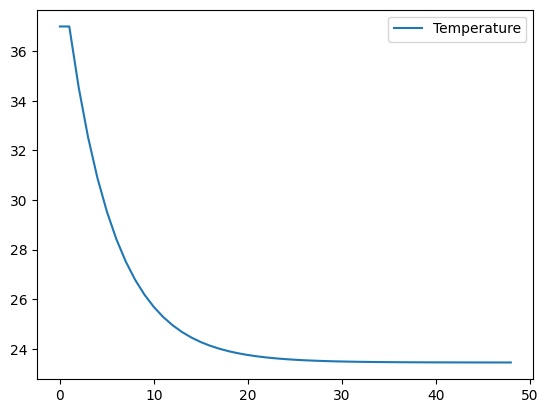

In [7]:
# Boucle Q-learning

# Override max_epoch to 1 for testing
max_epoch = 1

env.reset()
for epoch in range(max_epoch):
    internal_state, markov_state = env.reset()
    done = False
    total_reward = 0
    internal_states = [internal_state.clone()]
    while not done:
        action = agent.choose_action(markov_state)
        internal_state, reward, done, next_markov_state = env.step(action)
        agent.update_q_value(markov_state, action, reward, next_markov_state)
        markov_state = next_markov_state
        total_reward += reward
        internal_states.append(internal_state.clone())
    print(f"Epoch {epoch} - Total reward : {total_reward}")

# Affichage de l'évolution de la température
import matplotlib.pyplot as plt


plt.plot(internal_states, label="Temperature")
plt.legend()
plt.show()
